In [1]:
import numpy as np

# plotting 
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import PyPDF2

# data manager and analysis
import vodex as vx
import numan as nu

# writing files
import tifffile as tif

run this cell to get some handy functions:

In [2]:
def get_significant(p, p_control):
    
    significant_cells_stim = np.array(p)<0.05
    n_significant = np.sum(significant_cells_stim)
    print(f'significant stim only :{n_significant}')

    significant_cells_control = np.array(p_control)<0.05
    n_significant_control = np.sum(significant_cells_control)
    print(f'significant control only :{n_significant_control}')

    significant_cells = np.logical_and(significant_cells_stim,~significant_cells_control)
    n_significant = np.sum(significant_cells)
    print(f'significant stim but not control :{n_significant}')
    
    return significant_cells

def p_value_histogram(p,p_control):
    
    bins = np.arange(0,1.2,0.05)
    plt.hist(p, bins, alpha=0.5, label='stimulus')
    plt.hist(p_control, bins, alpha=0.5, label='control')
    plt.legend(loc='upper right')
    
def merge_pdfs(pdfs, filename):
    mergeFile = PyPDF2.PdfFileMerger()
    for pdf in pdfs:
        mergeFile.append(PyPDF2.PdfFileReader(pdf, 'rb'))
        os.remove(pdf)
    mergeFile.write(filename)

# Define experiment: 

In [10]:
# don't forget to give the conditions names - they are used for plotting. 
blank = vx.Condition(vx.Stimulus('blank','blank'), name = 'blank')
dot2 = vx.Condition(vx.Stimulus('2dot','2dot'), name = 'dot2')
dot3 = vx.Condition(vx.Stimulus('3dot','3dot'), name = 'dot3')
dot5 = vx.Condition(vx.Stimulus('5dot','5dot'), name = 'dot5')

spec = {}
spec['conditions'] = [blank,dot3,blank,dot2,blank,dot5,blank,dot2,blank,dot3,blank,
                    dot2,blank,dot5,blank,dot3,blank,dot5]
spec['timing'] = np.array([7,1,5,1,6,1,6,1,9,1,5,1,9,1,6,1,9,1])*52 # in frames
spec['project_dir'] = "E:/Peter/numan/20220421_ok08_abtl_h2bcamp6s_9dpf_2v3v5_2P_1/"
spec['frames_per_volume'] = 52

experiment = vx.Experiment.from_dic(spec)
experiment.summary()

Total of 8 files.
Check the order :
[ 0 ] 20220421_ok08_abtl_h2bcamp6s_9dpf_2v3v5_2P_1_MMStack_Pos0.ome.tif : 8910 frames
[ 1 ] 20220421_ok08_abtl_h2bcamp6s_9dpf_2v3v5_2P_1_MMStack_Pos0_1.ome.tif : 8909 frames
[ 2 ] 20220421_ok08_abtl_h2bcamp6s_9dpf_2v3v5_2P_1_MMStack_Pos0_2.ome.tif : 8909 frames
[ 3 ] 20220421_ok08_abtl_h2bcamp6s_9dpf_2v3v5_2P_1_MMStack_Pos0_3.ome.tif : 8909 frames
[ 4 ] 20220421_ok08_abtl_h2bcamp6s_9dpf_2v3v5_2P_1_MMStack_Pos0_4.ome.tif : 8909 frames
[ 5 ] 20220421_ok08_abtl_h2bcamp6s_9dpf_2v3v5_2P_1_MMStack_Pos0_5.ome.tif : 8909 frames
[ 6 ] 20220421_ok08_abtl_h2bcamp6s_9dpf_2v3v5_2P_1_MMStack_Pos0_6.ome.tif : 8909 frames
[ 7 ] 20220421_ok08_abtl_h2bcamp6s_9dpf_2v3v5_2P_1_MMStack_Pos0_7.ome.tif : 4092 frames

Cycle length: 3692
Condition ['blank']: for 364 frames
Condition ['3dot']: for 52 frames
Condition ['blank']: for 260 frames
Condition ['2dot']: for 52 frames
Condition ['blank']: for 312 frames
Condition ['5dot']: for 52 frames
Condition ['blank']: for 312 fra

## get the volume ids for the conditions that you will be comparing : 

In [6]:
def merge_idx(idx_list):
    return np.sort(np.concatenate(idx_list))

dot2_idx = experiment.select_volumes(dot2)
dot3_idx = experiment.select_volumes(dot3)
dot5_idx = experiment.select_volumes(dot5)
blank_idx = merge_idx([(dot2_idx-1), (dot3_idx-1), (dot5_idx-1)])

print(dot2_idx.shape, dot2_idx)
print(dot3_idx.shape, dot3_idx)
print(dot5_idx.shape, dot5_idx)
print(blank_idx.shape, blank_idx)

(54,) [  13   27   43   84   98  114  155  169  185  226  240  256  297  311
  327  368  382  398  439  453  469  510  524  540  581  595  611  652
  666  682  723  737  753  794  808  824  865  879  895  936  950  966
 1007 1021 1037 1078 1092 1108 1149 1163 1179 1220 1234 1250]
(54,) [   7   37   60   78  108  131  149  179  202  220  250  273  291  321
  344  362  392  415  433  463  486  504  534  557  575  605  628  646
  676  699  717  747  770  788  818  841  859  889  912  930  960  983
 1001 1031 1054 1072 1102 1125 1143 1173 1196 1214 1244 1267]
(54,) [  20   53   70   91  124  141  162  195  212  233  266  283  304  337
  354  375  408  425  446  479  496  517  550  567  588  621  638  659
  692  709  730  763  780  801  834  851  872  905  922  943  976  993
 1014 1047 1064 1085 1118 1135 1156 1189 1206 1227 1260 1277]
(162,) [   6   12   19   26   36   42   52   59   69   77   83   90   97  107
  113  123  130  140  148  154  161  168  178  184  194  201  211  219
  225  2

## Load spots from the Position and Diameter csv files produced by Imaris

In [14]:
imaris_csv_folder = 'E:/Peter/numan/imarisprocess/ok08_two_vs_five_t_score_Statistics/'
points_file = f'{imaris_csv_folder}ok08_two_vs_five_t_score_Position.csv'
diameter_file = f'{imaris_csv_folder}ok08_two_vs_five_t_score_Diameter.csv'

resolution = [4.8, 1.17, 1.17]
spots = nu.Spots.from_imaris(points_file,diameter_file,resolution = resolution, units='phs')

Get the raw signal for each spot : 

In [15]:
spots.get_signals(volumes="all", experiment=experiment, batch_size=100, traces_type="raw")

Batch [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98], t_start 0, t_end 99


100%|██████████| 5148/5148 [00:08<00:00, 642.59it/s]


Batch [ 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134
 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152
 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170
 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188
 189 190 191 192 193 194 195 196 197], t_start 99, t_end 198


100%|██████████| 5148/5148 [00:08<00:00, 610.99it/s]


Batch [198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251
 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269
 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287
 288 289 290 291 292 293 294 295 296], t_start 198, t_end 297


100%|██████████| 5148/5148 [00:08<00:00, 614.92it/s]


Batch [297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314
 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332
 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350
 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368
 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386
 387 388 389 390 391 392 393 394 395], t_start 297, t_end 396


100%|██████████| 5148/5148 [00:08<00:00, 612.22it/s]


Batch [396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413
 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431
 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449
 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467
 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485
 486 487 488 489 490 491 492 493], t_start 396, t_end 494


100%|██████████| 5096/5096 [00:08<00:00, 625.09it/s]


Batch [494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511
 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529
 530 531 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547
 548 549 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565
 566 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583
 584 585 586 587 588 589 590 591], t_start 494, t_end 592


100%|██████████| 5096/5096 [00:08<00:00, 611.23it/s]


Batch [592 593 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608 609
 610 611 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627
 628 629 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645
 646 647 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663
 664 665 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681
 682 683 684 685 686 687 688 689], t_start 592, t_end 690


100%|██████████| 5096/5096 [00:08<00:00, 609.43it/s]


Batch [690 691 692 693 694 695 696 697 698 699 700 701 702 703 704 705 706 707
 708 709 710 711 712 713 714 715 716 717 718 719 720 721 722 723 724 725
 726 727 728 729 730 731 732 733 734 735 736 737 738 739 740 741 742 743
 744 745 746 747 748 749 750 751 752 753 754 755 756 757 758 759 760 761
 762 763 764 765 766 767 768 769 770 771 772 773 774 775 776 777 778 779
 780 781 782 783 784 785 786 787], t_start 690, t_end 788


100%|██████████| 5096/5096 [00:08<00:00, 613.91it/s]


Batch [788 789 790 791 792 793 794 795 796 797 798 799 800 801 802 803 804 805
 806 807 808 809 810 811 812 813 814 815 816 817 818 819 820 821 822 823
 824 825 826 827 828 829 830 831 832 833 834 835 836 837 838 839 840 841
 842 843 844 845 846 847 848 849 850 851 852 853 854 855 856 857 858 859
 860 861 862 863 864 865 866 867 868 869 870 871 872 873 874 875 876 877
 878 879 880 881 882 883 884 885], t_start 788, t_end 886


100%|██████████| 5096/5096 [00:08<00:00, 609.67it/s]


Batch [886 887 888 889 890 891 892 893 894 895 896 897 898 899 900 901 902 903
 904 905 906 907 908 909 910 911 912 913 914 915 916 917 918 919 920 921
 922 923 924 925 926 927 928 929 930 931 932 933 934 935 936 937 938 939
 940 941 942 943 944 945 946 947 948 949 950 951 952 953 954 955 956 957
 958 959 960 961 962 963 964 965 966 967 968 969 970 971 972 973 974 975
 976 977 978 979 980 981 982 983], t_start 886, t_end 984


100%|██████████| 5096/5096 [00:08<00:00, 614.89it/s]


Batch [ 984  985  986  987  988  989  990  991  992  993  994  995  996  997
  998  999 1000 1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011
 1012 1013 1014 1015 1016 1017 1018 1019 1020 1021 1022 1023 1024 1025
 1026 1027 1028 1029 1030 1031 1032 1033 1034 1035 1036 1037 1038 1039
 1040 1041 1042 1043 1044 1045 1046 1047 1048 1049 1050 1051 1052 1053
 1054 1055 1056 1057 1058 1059 1060 1061 1062 1063 1064 1065 1066 1067
 1068 1069 1070 1071 1072 1073 1074 1075 1076 1077 1078 1079 1080 1081], t_start 984, t_end 1082


100%|██████████| 5096/5096 [00:08<00:00, 616.64it/s]


Batch [1082 1083 1084 1085 1086 1087 1088 1089 1090 1091 1092 1093 1094 1095
 1096 1097 1098 1099 1100 1101 1102 1103 1104 1105 1106 1107 1108 1109
 1110 1111 1112 1113 1114 1115 1116 1117 1118 1119 1120 1121 1122 1123
 1124 1125 1126 1127 1128 1129 1130 1131 1132 1133 1134 1135 1136 1137
 1138 1139 1140 1141 1142 1143 1144 1145 1146 1147 1148 1149 1150 1151
 1152 1153 1154 1155 1156 1157 1158 1159 1160 1161 1162 1163 1164 1165
 1166 1167 1168 1169 1170 1171 1172 1173 1174 1175 1176 1177 1178 1179], t_start 1082, t_end 1180


100%|██████████| 5096/5096 [00:07<00:00, 652.54it/s]


Batch [1180 1181 1182 1183 1184 1185 1186 1187 1188 1189 1190 1191 1192 1193
 1194 1195 1196 1197 1198 1199 1200 1201 1202 1203 1204 1205 1206 1207
 1208 1209 1210 1211 1212 1213 1214 1215 1216 1217 1218 1219 1220 1221
 1222 1223 1224 1225 1226 1227 1228 1229 1230 1231 1232 1233 1234 1235
 1236 1237 1238 1239 1240 1241 1242 1243 1244 1245 1246 1247 1248 1249
 1250 1251 1252 1253 1254 1255 1256 1257 1258 1259 1260 1261 1262 1263
 1264 1265 1266 1267 1268 1269 1270 1271 1272 1273 1274 1275 1276 1277], t_start 1180, t_end 1278


100%|██████████| 5096/5096 [00:08<00:00, 601.19it/s]


## Find significant cells for 2vs5 , 2vs3, 3vs5

Getting p-values for stim
 Data points in group 1 : 54,in group 1 : 54.
Number of spots : 112.


100%|██████████| 112/112 [01:18<00:00,  1.43it/s]


Getting p-values for blank before stim
 Data points in group 1 : 54,in group 1 : 54.
Number of spots : 112.


100%|██████████| 112/112 [01:20<00:00,  1.38it/s]


Summary : 
significant stim only :43
significant control only :8
significant stim but not control :39


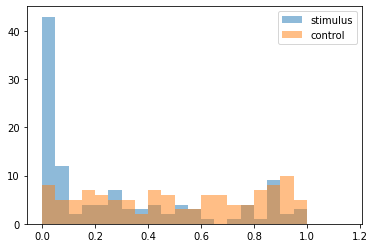

In [16]:
def get_p_and_control(sa, group1_idx, group2_idx, name_p):
    print( f"Getting p-values for stim : {name_p}")
    p = sa.get_p_list_of_difference_of_means(group1_idx, group2_idx)
    print( f"Getting p-values for blank before stim: {name_p}")
    p_control = sa.get_p_list_of_difference_of_means(group1_idx-1, group2_idx-1)
    return p, p_control

np.random.seed(42)

# get dff for each cell
sliding_window = 15 # in volumes
signals_dff = spots.signals.as_dff(sliding_window)

# calculate p-values using bootstrap
sa = nu.SignalAnalyzer(signals_dff)

p2v5, p2v5_c = get_p_and_control(sa, dot2_idx, dot5_idx, "2vs5")
p3v5, p3v5_c = get_p_and_control(sa, dot3_idx, dot5_idx, "3vs5")
p2v3, p2v3_c = get_p_and_control(sa, dot2_idx, dot3_idx, "2vs3")


# show histogram, determine significance 
print( "Summary 2v5: ")
p_value_histogram(p2v5, p2v5_c)
print( "Summary 3v5: ")
p_value_histogram(p3v5, p3v5_c)
print( "Summary 2v3: ")
p_value_histogram(p2v3, p2v3_c)

sig2v5 = get_significant(p2v5, p2v5_c)
sig3v5 = get_significant(p3v5, p3v5_c)
sig2v3 = get_significant(p2v3, p2v3_c)

# add the p-values and significance info to the spots
spots.add_groups({"p2v5":p2v5, "p2v5_c":p2v5_c, "sig2v5":sig2v5,
                  "p3v5":p3v5, "p3v5_c":p3v5_c, "sig3v5":sig3v5,
                  "p2v3":p2v3, "p2v3_c":p2v3_c, "sig2v3":sig2v3})

# Save Significant Cells as Json 

In [ ]:
spots.to_json(f"E:/Peter/numan/spots/2vs5_3vs5_2vs3_cells.json")

# Save Significant Cells as tif 

In [18]:
sig2v5_mask = spots.get_group_mask(spots.groups["sig2v5"], (52, 468, 500))
sig3v5_mask = spots.get_group_mask(spots.groups["sig3v5"], (52, 468, 500))
sig2v3_mask = spots.get_group_mask(spots.groups["sig2v3"], (52, 468, 500))

tif.imwrite("E:/Peter/numan/spots/significant_cells_mask_2v5.tif",
                   sig2v5_mask.astype(np.uint16),shape=(52,468,500),metadata={'axes': 'ZYX'}, imagej=True)
tif.imwrite("E:/Peter/numan/spots/significant_cells_mask_3v5.tif",
                   sig3v5_mask.astype(np.uint16),shape=(52,468,500),metadata={'axes': 'ZYX'}, imagej=True)
tif.imwrite("E:/Peter/numan/spots/significant_cells_mask_2v3.tif",
                   sig2v3_mask.astype(np.uint16),shape=(52,468,500),metadata={'axes': 'ZYX'}, imagej=True)

100%|██████████| 39/39 [00:04<00:00,  8.81it/s]


In [5]:
spots = nu.Spots.from_json(f"D:/Code/repos/numan/notebooks/data/2vs5_3vs5_2vs3_cells.json")

In [20]:
np.sum(spots.groups['sig2v3'])

30

# (the end of the fixed notebook) Plot significant signals

## Create a pdf with all the traces : 

### 2v5 : 

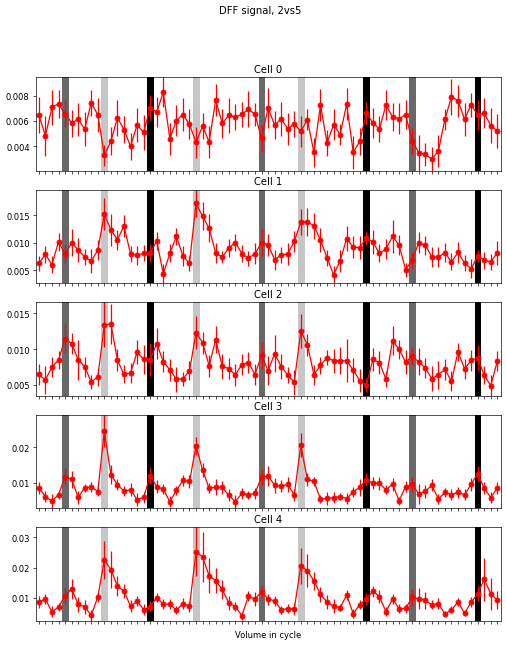

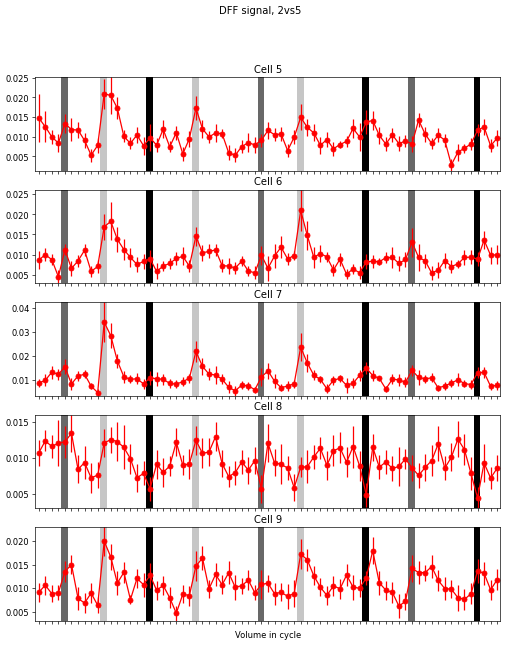

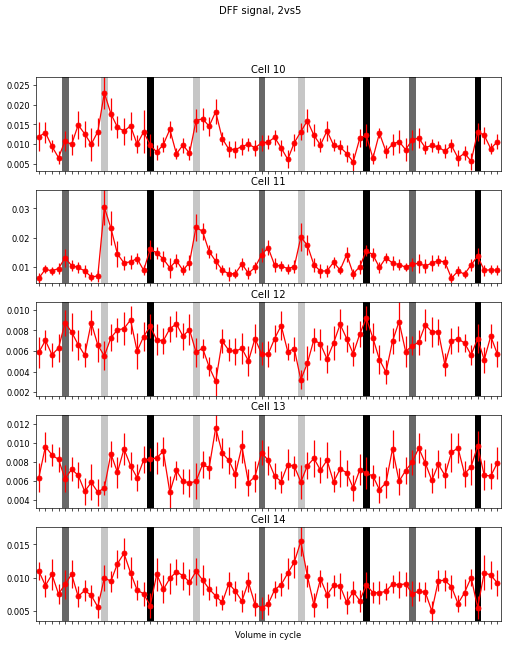

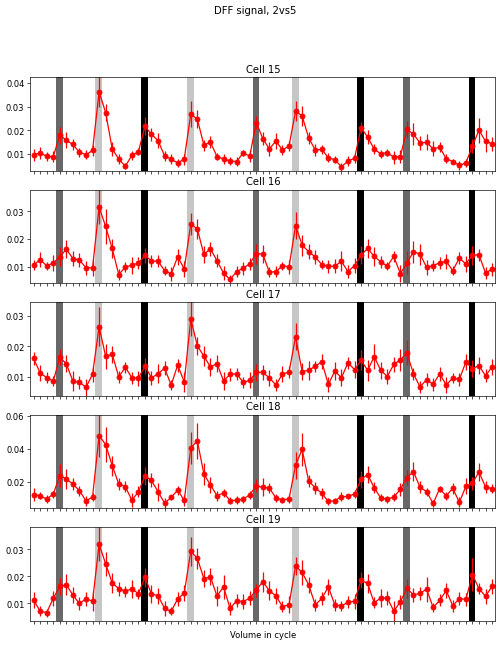

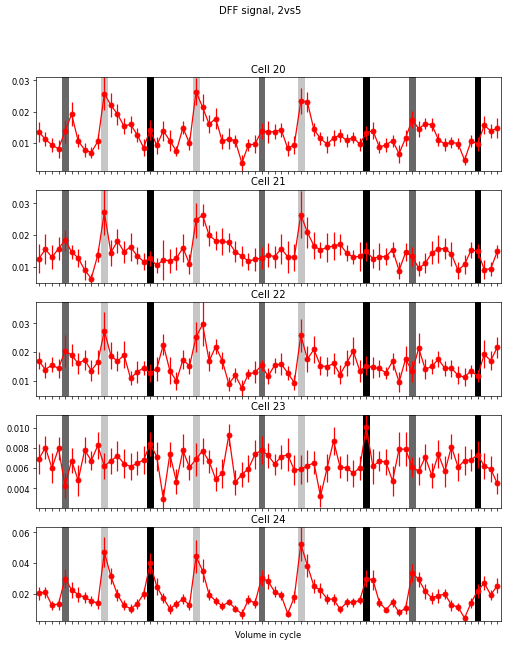

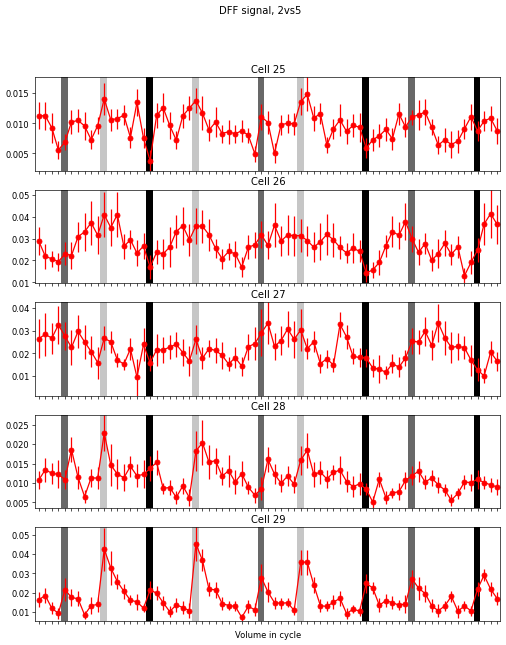

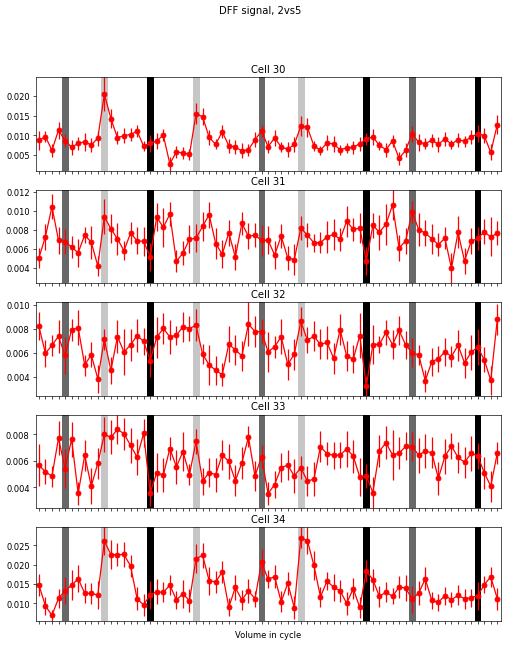

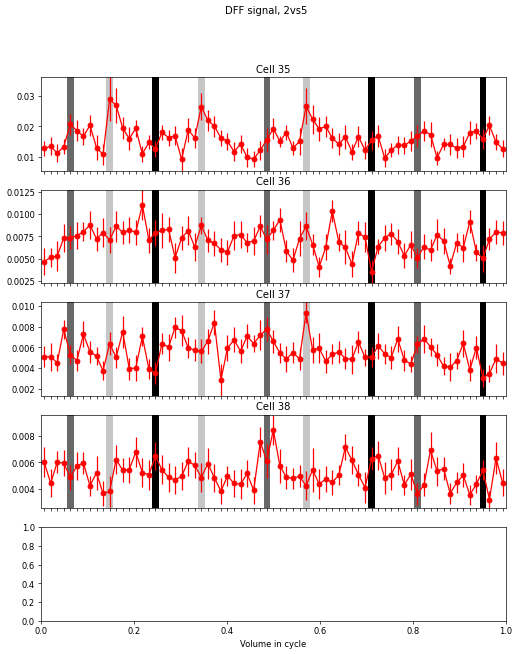

In [23]:
sliding_window = 15 # in volumes, to create dff
significant_signals = spots.get_group_signals(spots.groups['sig2v5'])
significant_signals_dff = significant_signals.as_dff(sliding_window)
sp = nu.SignalPlotter(significant_signals_dff, experiment)

tpp = 5 # traces per page
cells = np.arange(sp.n_signals)
btchs = [cells[s: s+tpp] for s in np.arange(np.ceil(sp.n_signals / tpp).astype(int))*tpp]

main_title = "DFF signal, 2vs5"

# indifidual pdf pages will be saved to this folder, but will be deleted right after the merge 
tmp_folder = 'E:/Peter/numan//processed/spots/'
# filename to save pdf with all the significant traces
pdf_filename = f'E:/Peter/numan//processed/spots/significant_signals_sem_mean_only_good_order_2v5.pdf'

pdfs = []
for ibtch, btch in enumerate(btchs):
    titles = [f"Cell {ipt}" for ipt in btch]
    sp.show_psh(btch, 
                main_title, 
                titles,
                # front_to_tail will shift the cycleby the set number of voxels
                # so when set to 3, there are 3 blank volumes at the begining and at the end ... 
                # if set to 0, will have 6 leading blanks and will end right after the 5 dots (black bar)
                front_to_tail = 3, 
                # what grid to use to show the points
                figure_layout = [5,1] ,
                # what error type to use ( "sem" for SEM or "prc" for 5th - 95th percentile )
                error_type = "sem",
                # figure parameters
                figsize = (10, 12),
                dpi = 60,
                # wheather to plot the individual traces 
                plot_individual = False,
                # the color of the individual traces (if shown)
                noise_color = '--c')

    plt.xlabel('Volume in cycle')
    filename = f'{tmp_folder}signals_batch{ibtch}.pdf'
    plt.savefig(filename)
    pdfs.append(filename)
    

merge_pdfs(pdfs, pdf_filename)

### 2v3 : 

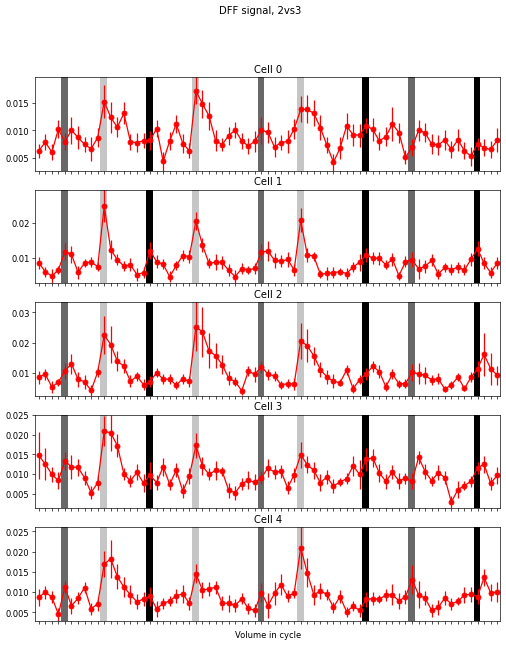

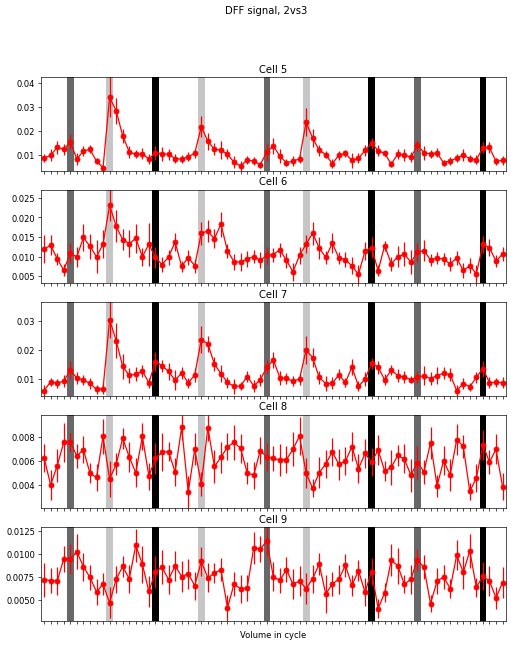

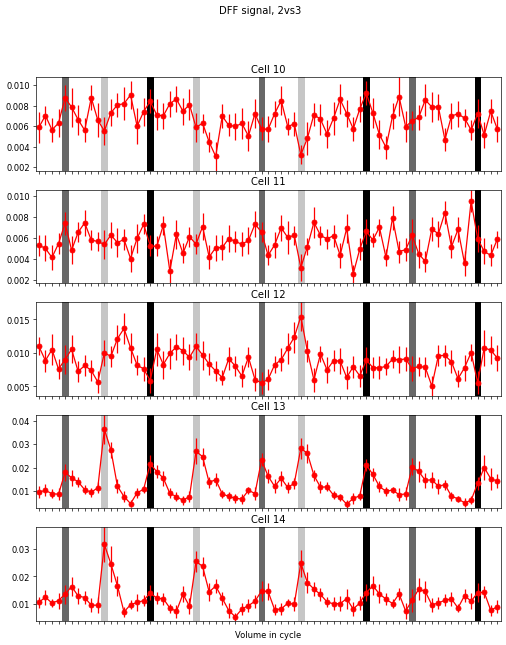

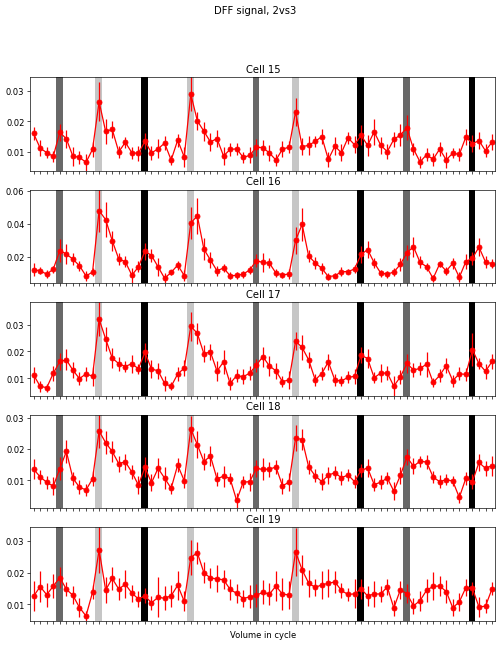

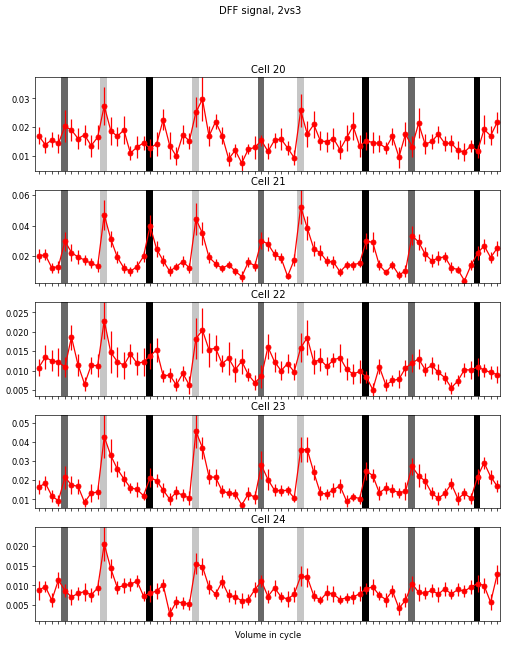

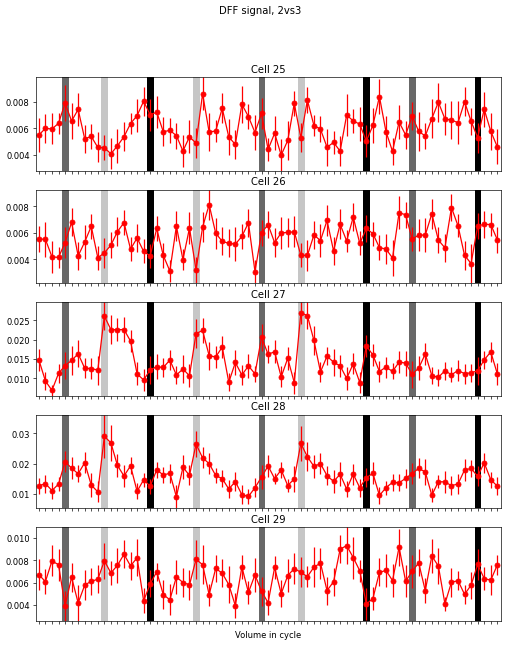

In [24]:
sliding_window = 15 # in volumes, to create dff
significant_signals = spots.get_group_signals(spots.groups['sig2v3'])
significant_signals_dff = significant_signals.as_dff(sliding_window)
sp = nu.SignalPlotter(significant_signals_dff, experiment)

tpp = 5 # traces per page
cells = np.arange(sp.n_signals)
btchs = [cells[s: s+tpp] for s in np.arange(np.ceil(sp.n_signals / tpp).astype(int))*tpp]

main_title = "DFF signal, 2vs3"

# indifidual pdf pages will be saved to this folder, but will be deleted right after the merge 
tmp_folder = 'E:/Peter/numan//processed/spots/'
# filename to save pdf with all the significant traces
pdf_filename = f'E:/Peter/numan//processed/spots/significant_signals_sem_mean_only_good_order_2v3.pdf'

pdfs = []
for ibtch, btch in enumerate(btchs):
    titles = [f"Cell {ipt}" for ipt in btch]
    sp.show_psh(btch, 
                main_title, 
                titles,
                # front_to_tail will shift the cycleby the set number of voxels
                # so when set to 3, there are 3 blank volumes at the begining and at the end ... 
                # if set to 0, will have 6 leading blanks and will end right after the 5 dots (black bar)
                front_to_tail = 3, 
                # what grid to use to show the points
                figure_layout = [5,1] ,
                # what error type to use ( "sem" for SEM or "prc" for 5th - 95th percentile )
                error_type = "sem",
                # figure parameters
                figsize = (10, 12),
                dpi = 60,
                # wheather to plot the individual traces 
                plot_individual = False,
                # the color of the individual traces (if shown)
                noise_color = '--c')

    plt.xlabel('Volume in cycle')
    filename = f'{tmp_folder}signals_batch{ibtch}.pdf'
    plt.savefig(filename)
    pdfs.append(filename)
    

merge_pdfs(pdfs, pdf_filename)

### 3v5 : 

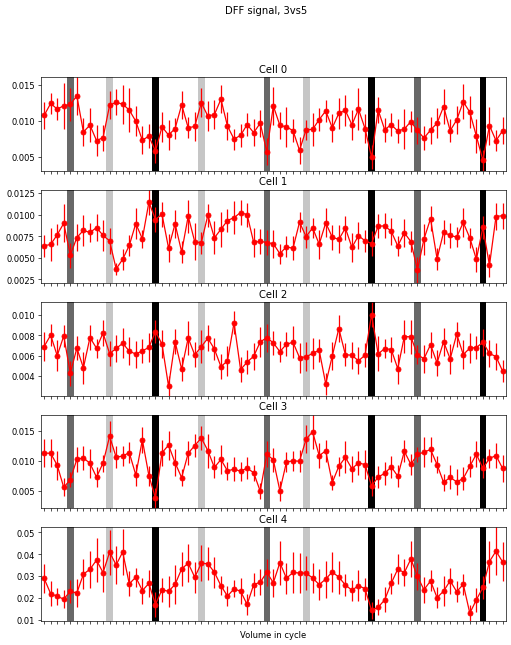

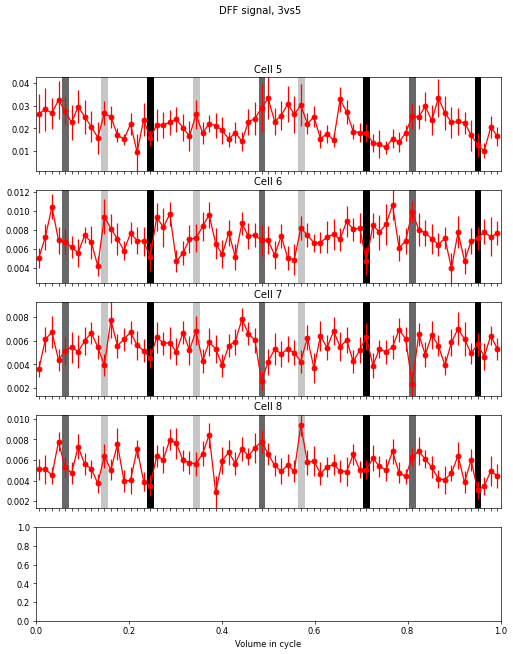

In [25]:
sliding_window = 15 # in volumes, to create dff
significant_signals = spots.get_group_signals(spots.groups['sig3v5'])
significant_signals_dff = significant_signals.as_dff(sliding_window)
sp = nu.SignalPlotter(significant_signals_dff, experiment)

tpp = 5 # traces per page
cells = np.arange(sp.n_signals)
btchs = [cells[s: s+tpp] for s in np.arange(np.ceil(sp.n_signals / tpp).astype(int))*tpp]

main_title = "DFF signal, 3vs5"

# indifidual pdf pages will be saved to this folder, but will be deleted right after the merge 
tmp_folder = 'E:/Peter/numan//processed/spots/'
# filename to save pdf with all the significant traces
pdf_filename = f'E:/Peter/numan//processed/spots/significant_signals_sem_mean_only_good_order_3v5.pdf'

pdfs = []
for ibtch, btch in enumerate(btchs):
    titles = [f"Cell {ipt}" for ipt in btch]
    sp.show_psh(btch, 
                main_title, 
                titles,
                # front_to_tail will shift the cycleby the set number of voxels
                # so when set to 3, there are 3 blank volumes at the begining and at the end ... 
                # if set to 0, will have 6 leading blanks and will end right after the 5 dots (black bar)
                front_to_tail = 3, 
                # what grid to use to show the points
                figure_layout = [5,1] ,
                # what error type to use ( "sem" for SEM or "prc" for 5th - 95th percentile )
                error_type = "sem",
                # figure parameters
                figsize = (10, 12),
                dpi = 60,
                # wheather to plot the individual traces 
                plot_individual = False,
                # the color of the individual traces (if shown)
                noise_color = '--c')

    plt.xlabel('Volume in cycle')
    filename = f'{tmp_folder}signals_batch{ibtch}.pdf'
    plt.savefig(filename)
    pdfs.append(filename)
    

merge_pdfs(pdfs, pdf_filename)